### MODEL TUNNING
- ### INCREASED FINAL DROPUT LAYER TO 0,2 TO AVOID OVERFITTING
- ### REDUCED BATCH TO 320


### Import Required Libraries

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

UsageError: Line magic function `%` not found.


### Read Data

Our data is a text file of English-Spanish sentence pairs. First we will read the file using the function defined below.

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-Spanish pairs separated by '\n' and then split these pairs into English sentences and Spanish sentences.

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "spa.txt" in your working directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/NLP_Julia

In [5]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)[:,0:2] #NOS QUEDAMOS SOLO CON LAS PRIMERAS COLUMNAS QUE TIENEN LA INFORMACION

The actual data contains over 150,000 sentence-pairs. However, we will use the first 80,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [6]:
#PARA ENTRENAR EL PRIMER MODELO VOY A USARLAS TODAS ASI QUE COMENTO ESTA LINEA
spa_eng = spa_eng[:80000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [7]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Suddenly, all the lights went out.',
        'De repente se apagaron todas las luces.'],
       ['Suddenly, the dog started barking.',
        'De repente el perro empezó a ladrar.'],
       ['Swimming in the pond is dangerous.',
        'Es peligroso nadar en la laguna.']], dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

#### *IMPORTANTE QUITAR LA EXCLAMACION HACIA ARRIBA PARA EL ESPAÑOL



In [8]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

## TAMBIEN QUITAMOS ESTA EXCLAMACION QUE LO ANTERIOR NO LO QUITA
spa_eng[:,0] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,1]]

# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [9]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['suddenly all the lights went out',
        'de repente se apagaron todas las luces'],
       ['suddenly the dog started barking',
        'de repente el perro empezó a ladrar'],
       ['swimming in the pond is dangerous',
        'es peligroso nadar en la laguna']], dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and Spanish, respectively.

In [10]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [11]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
#print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

10
15


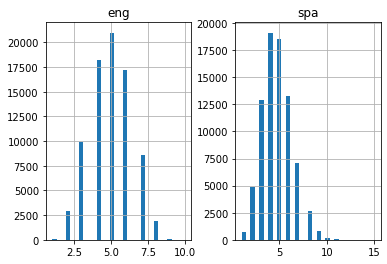

In [12]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the Spanish sentences is 15 and that of the English phrases is 10.


Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [13]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [14]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 15
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 9440


In [15]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 15
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 18823


In [16]:
##print(spa_tokenizer.word_counts)

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [17]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode Spanish sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [19]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[  11  246    4 ...    0    0    0]
 [  93   15    7 ...    0    0    0]
 [  40    6    4 ...    0    0    0]
 ...
 [  14  292  100 ...    0    0    0]
 [  52  250 2008 ...    0    0    0]
 [  18  127 1589 ...    0    0    0]]
64000
[[   1  223    2 ...    0    0    0]
 [ 388    5 1608 ...    0    0    0]
 [  12    7   92 ...    0    0    0]
 ...
 [   2  117   10 ...    0    0    0]
 [  55  480  576 ...    0    0    0]
 [  13  165  850 ...    0    0    0]]
64000


In [20]:
print(trainX.shape)
print(trainY.shape)

(64000, 15)
(64000, 15)


In [21]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[   1  946 7114 ...    0    0    0]
 [  25 6256    0 ...    0    0    0]
 [ 747   33  121 ...    0    0    0]
 ...
 [   3    1    2 ...    0    0    0]
 [ 189  236  451 ...    0    0    0]
 [7627 3437 2486 ...    0    0    0]]
16000
[[   3  350   33 ...    0    0    0]
 [1172   10    0 ...    0    0    0]
 [  57   62   97 ...    0    0    0]
 ...
 [   3   87   29 ...    0    0    0]
 [ 133    1   59 ...    0    0    0]
 [  90  856   24 ...    0    0    0]]
16000


In [22]:
print(testX.shape)
print(testY.shape)

(16000, 15)
(16000, 15)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [23]:
# build NMT model (LSTM)
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [24]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

18823
9440
15
15


In [25]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 35 epochs and with a batch size of 320. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [26]:
filename = 'modelLSTM5.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=35, batch_size=320, #512 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/home/jhelena/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 51200 samples, validate on 12800 samples
Epoch 1/35
51200/51200 [==============================] - 162s 3ms/step - loss: 2.3598 - val_loss: 2.1248

Epoch 00001: val_loss improved from inf to 2.12483, saving model to modelLSTM5.h1
Epoch 2/35
51200/51200 [==============================] - 161s 3ms/step - loss: 1.9986 - val_loss: 1.9802

Epoch 00002: val_loss improved from 2.12483 to 1.98017, saving model to modelLSTM5.h1
Epoch 3/35
51200/51200 [==============================] - 161s 3ms/step - loss: 1.8825 - val_loss: 1.8430

Epoch 00003: val_loss improved from 1.98017 to 1.84301, saving model to modelLSTM5.h1
Epoch 4/35
51200/51200 [==============================] - 160s 3ms/step - loss: 1.7550 - val_loss: 1.7180

Epoch 00004: val_loss improved from 1.84301 to 1.71797, saving model to modelLSTM5.h1
Epoch 5/35
51200/51200 [==============================] - 161s 3ms/step - loss: 1.6252 - val_loss: 1.6187

Epoch 00005: val_loss improved from 1.71797 to 1.61870, saving model to mod

Let's compare the training loss and the validation loss.

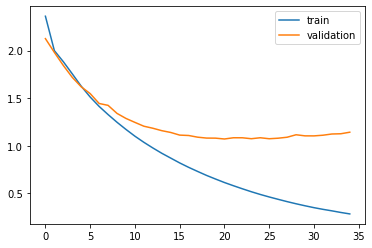

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [28]:
model = load_model('modelLSTM5.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/home/jhelena/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [29]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [30]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [31]:
pred_df = pd.DataFrame({'Spanish':  test[:,1], 'actual traduction' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [32]:
pred_df.head(15)

,Spanish,actual traduction,predicted
0,tom sentía temblar sus rodillas,tom felt his knees tremble,tom lost his
1,eso valdrá,thatll do,thatll do
2,volveré más tarde,ill come back later,ill will back later
3,estoy reventado,i am exhausted,im exhausted
4,no lo hagáis,dont do it,dont ask it
5,me duele la muela del juicio superior derecha,my upper right wisdom tooth hurts,my only
6,ya lo has olvidado,youve already forgotten,youve already
7,¿por qué llevas un suéter,why are you wearing a sweater,why are you wearing a coat
8,no me subestimes,dont underestimate me,dont ask me
9,eso fue idea mía,it was my idea,that was my idea


In [33]:
pred_df.sample(15)

,Spanish,actual traduction,predicted
9806,es solo que no quiero decepcionarte,i just dont want to let you down,it just want to waste
7729,tú me diviertes,you amuse me,you worried me
10138,no quise lastimarte,i didnt want to hurt you,i didnt want to hurt you
1173,¿puedo preguntarle cuál prefiere,may i ask which you prefer,may i ask how to
5076,¿estás enfadado conmigo,are you angry with me,are you angry with me
800,¿quieres decir algo,do you want to say something,do you want something say something
2869,¿qué ocurre cuando mueres,what happens when you die,what time he come
5962,tom espera verte en octubre,tom hopes to see you in october,tom will to stay tv
1908,cualquier lugar con cama estará bien,anywhere with a bed will do,after us to gets
982,me perdí en el bosque,i lost my way in the forest,i got lost in the woods
